In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from datetime import date, time, datetime, timedelta

In [2]:
# Vanos a revisar la información del dataset
info = open('taxi-1.txt')
print('La información del dataset es: ')
print(info.read())

La información del dataset es: 
'trip_duration': How long did the journey last?[in Seconds]
'distance_traveled': How far did the taxi travel?[in Km]
'num_of_passengers': How many passengers were in the taxi?
'fare': What's the base fare for the journey?[In INR]
'tip': How much did the driver receive in tips?[In INR]
'miscellaneous_fees': Were there any additional charges during the trip?e.g. tolls, convenience fees, GST, etc.[In INR]
'total_fare': The grand total for the ride (this is your prediction target!).[In INR]
'surge_applied': Was there a surge pricing applied? Yes or no?


In [3]:
# Datos en bruto
df_taxi = pd.read_csv('train.csv')
df_taxi.head()

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,total_fare,surge_applied
0,748.0,2.75,1.0,75.00,24,6.300,105.300,0
1,1187.0,3.43,1.0,105.00,24,13.200,142.200,0
2,730.0,3.12,1.0,71.25,0,26.625,97.875,1
3,671.0,5.63,3.0,90.00,0,9.750,99.750,0
4,329.0,2.09,1.0,45.00,12,13.200,70.200,0


In [4]:
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209673 entries, 0 to 209672
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   trip_duration       209673 non-null  float64
 1   distance_traveled   209673 non-null  float64
 2   num_of_passengers   209673 non-null  float64
 3   fare                209673 non-null  float64
 4   tip                 209673 non-null  int64  
 5   miscellaneous_fees  209673 non-null  float64
 6   total_fare          209673 non-null  float64
 7   surge_applied       209673 non-null  int64  
dtypes: float64(6), int64(2)
memory usage: 12.8 MB


In [5]:
df_taxi.shape

(209673, 8)

In [6]:
#Vamos a añadir una nueva columna con la duración en formato timedelta
df_taxi['trip_duration_hh_mm_ss'] = pd.to_timedelta(df_taxi['trip_duration'], unit='s')
#La columna num_of_passengers a int
df_taxi['num_of_passengers'] = df_taxi['num_of_passengers'].astype('int')
#La columna tip a float
df_taxi['tip'] = df_taxi['tip'].astype('float')
#La columna surge surge_applied a booleano
df_taxi['surge_applied'] = df_taxi['surge_applied'].astype('bool')

In [7]:
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209673 entries, 0 to 209672
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype          
---  ------                  --------------   -----          
 0   trip_duration           209673 non-null  float64        
 1   distance_traveled       209673 non-null  float64        
 2   num_of_passengers       209673 non-null  int64          
 3   fare                    209673 non-null  float64        
 4   tip                     209673 non-null  float64        
 5   miscellaneous_fees      209673 non-null  float64        
 6   total_fare              209673 non-null  float64        
 7   surge_applied           209673 non-null  bool           
 8   trip_duration_hh_mm_ss  209673 non-null  timedelta64[ns]
dtypes: bool(1), float64(6), int64(1), timedelta64[ns](1)
memory usage: 13.0 MB


In [8]:
#Comprobamos si hay nulos
df_taxi.isna().sum()

trip_duration             0
distance_traveled         0
num_of_passengers         0
fare                      0
tip                       0
miscellaneous_fees        0
total_fare                0
surge_applied             0
trip_duration_hh_mm_ss    0
dtype: int64

total_fare debería de ser la suma de fare + tip + miscellaneous_fees. Vamos a ver si hay alguna columna que haya que corregir

In [9]:
df_taxi[df_taxi['total_fare'] != (df_taxi['fare']+df_taxi['tip']+df_taxi['miscellaneous_fees'])]

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,total_fare,surge_applied,trip_duration_hh_mm_ss
160437,109.0,0.48,1,26.25,10.0,27.125,63.375,True,0 days 00:01:49


sería necesario corregir esa columna

In [10]:
df_taxi.loc[160437, 'total_fare'] = df_taxi.loc[160437, 'fare']+df_taxi.loc[160437, 'tip']+df_taxi.loc[160437, 'miscellaneous_fees']

Comprobaremos si hay datos a cero

In [11]:
df_taxi[df_taxi['total_fare'] == 0]

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,total_fare,surge_applied,trip_duration_hh_mm_ss
2385,82.0,0.16,1,0.0,0.0,0.0,0.0,False,0 days 00:01:22
2389,588.0,2.41,1,0.0,0.0,0.0,0.0,False,0 days 00:09:48
6706,1330.0,5.15,1,0.0,0.0,0.0,0.0,False,0 days 00:22:10
7467,3669.0,8.37,3,0.0,0.0,0.0,0.0,False,0 days 01:01:09
7906,3688.0,22.85,1,0.0,0.0,0.0,0.0,False,0 days 01:01:28
...,...,...,...,...,...,...,...,...,...
196978,38.0,0.64,1,0.0,0.0,0.0,0.0,False,0 days 00:00:38
201515,3796.0,17.70,1,0.0,0.0,0.0,0.0,False,0 days 01:03:16
201900,5259.0,39.75,2,0.0,0.0,0.0,0.0,False,0 days 01:27:39
204870,27.0,0.16,1,0.0,0.0,0.0,0.0,False,0 days 00:00:27


Eliminamos esos datos

In [12]:
df_taxi = df_taxi[df_taxi['total_fare'] != 0]

Vamos a buscar datos atipicos

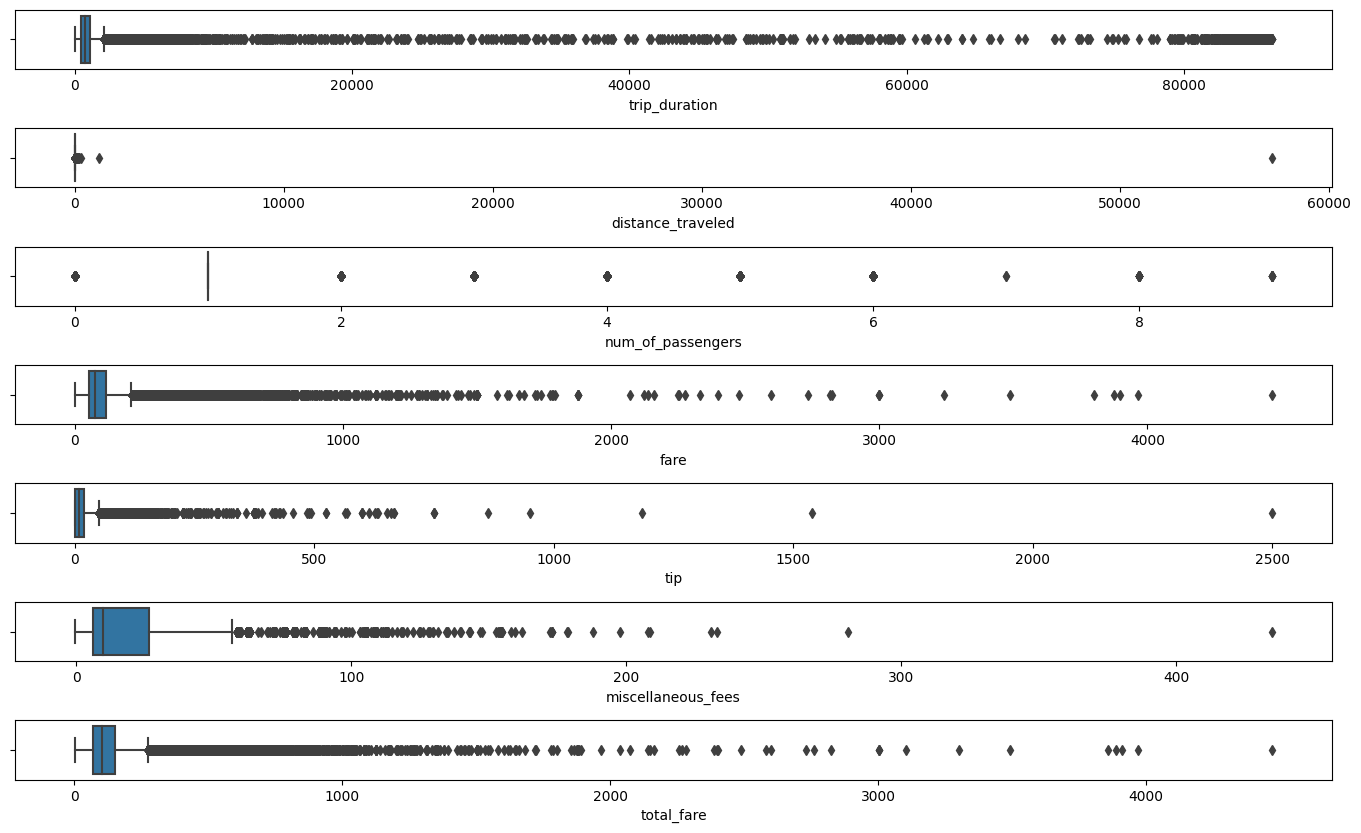

In [13]:
fig, ax = plt.subplots(nrows=7, ncols=1, figsize=(17,10))
fig.subplots_adjust(hspace=1)

for i, col in enumerate(['trip_duration', 'distance_traveled', 'num_of_passengers', 'fare',
       'tip', 'miscellaneous_fees', 'total_fare']):
    sns.boxplot(x=col, data=df_taxi, ax=ax[i])

Como primer vistazo, observamos que la columna num_of_passengers no tiene relevancia  
El hecho de que viaje más de una persona se considera atipico, así que la eliminamos, porque parece que no nos va a aportar información.

In [14]:
df_taxi.pop('num_of_passengers')

0         1
1         1
2         1
3         3
4         1
         ..
209668    1
209669    1
209670    1
209671    1
209672    1
Name: num_of_passengers, Length: 209544, dtype: int64

Creamos un nuevo dataset con los atipicos eliminados

In [15]:
#Creamos un df con la variable para recortar
variablerecorte = df_taxi[['trip_duration']]
#Calculamos los cuartiles
qs = variablerecorte.quantile([.25, .5, .75], numeric_only=True).values
q1 = qs[0][0]
q2 = qs[1][0]
q3 = qs[2][0]
# Definir límites inferior y superior, a partir de los cuales los datos serían considerados como atípicos
iqr = q3-q1
iqr_lim_inf = q1 - 1.5*iqr
iqr_lim_sup = q3 + 1.5*iqr
#Aquí le indicamos que cree un dataset sin los atipicos
df_taxi_sinatipicos = df_taxi[
    (df_taxi['trip_duration']>=iqr_lim_inf) & (df_taxi['trip_duration']<=iqr_lim_sup)
]
print(f'Tamaño dataset original: {df_taxi.shape}')
print(f'Tamaño dataset recortado: {df_taxi_sinatipicos.shape}')

Tamaño dataset original: (209544, 8)
Tamaño dataset recortado: (197677, 8)


Vamos a ver si sólamente eliminando esos atípicos tendríamos un dataset manejable

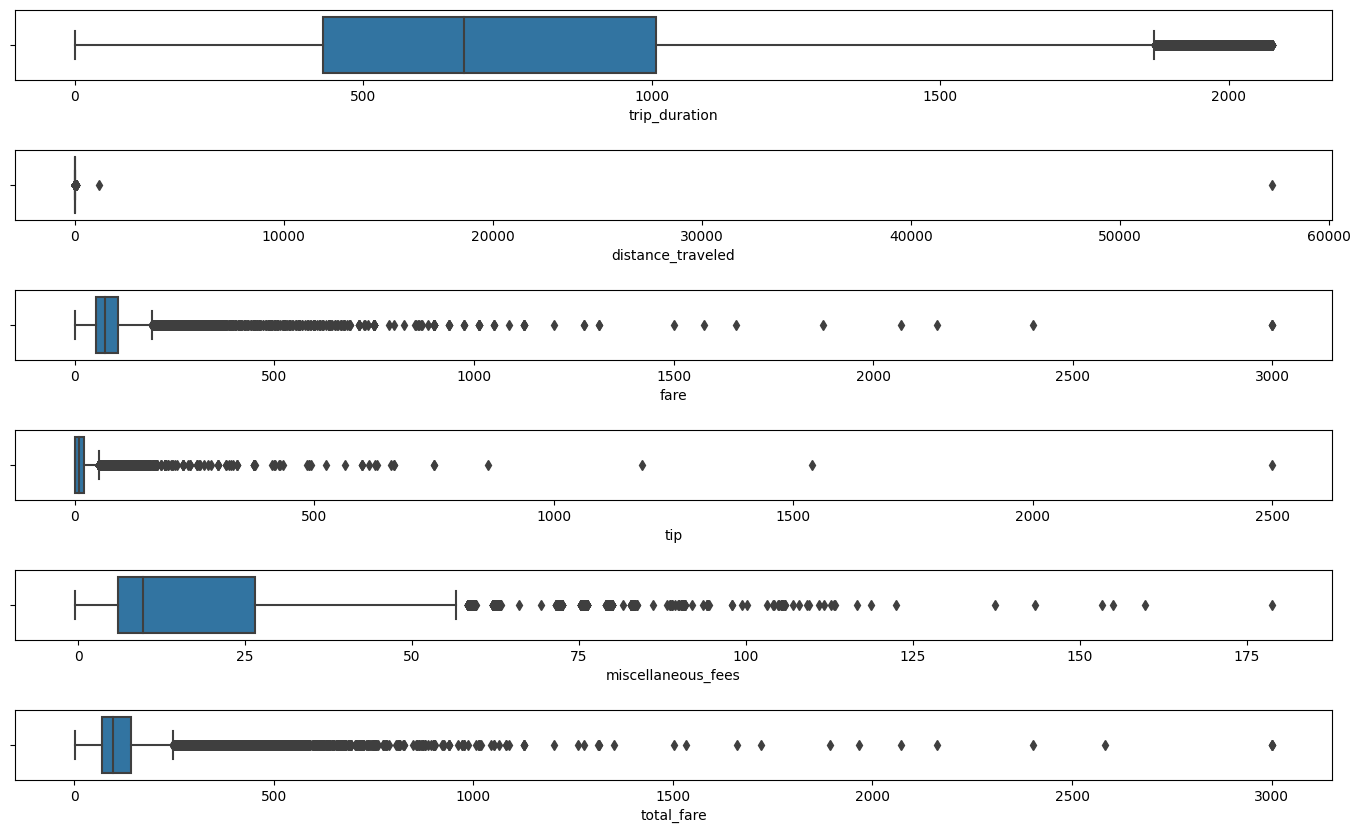

In [16]:
fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(17,10))
fig.subplots_adjust(hspace=1)

for i, col in enumerate(['trip_duration', 'distance_traveled', 'fare',
       'tip', 'miscellaneous_fees', 'total_fare']):
    sns.boxplot(x=col, data=df_taxi_sinatipicos, ax=ax[i])

Como todavía quedan muchos atípicos, vamos a ver que sucede eliminando los atipicos de 'total_fare'

In [17]:
print(f'Tamaño dataset anterior: {df_taxi_sinatipicos.shape}')
#Creamos un df con la variable para recortar
variablerecorte = df_taxi[['total_fare']]
#Calculamos los cuartiles
qs = variablerecorte.quantile([.25, .5, .75], numeric_only=True).values
q1 = qs[0][0]
q2 = qs[1][0]
q3 = qs[2][0]
# Definir límites inferior y superior, a partir de los cuales los datos serían considerados como atípicos
iqr = q3-q1
iqr_lim_inf = q1 - 1.5*iqr
iqr_lim_sup = q3 + 1.5*iqr
#Aquí le indicamos que elimine los atipicos del nuevo dataframe
df_taxi_sinatipicos = df_taxi_sinatipicos[
    (df_taxi_sinatipicos['total_fare']>=iqr_lim_inf) & (df_taxi_sinatipicos['total_fare']<=iqr_lim_sup)
]
print(f'Tamaño dataset recortado: {df_taxi_sinatipicos.shape}')

Tamaño dataset anterior: (197677, 8)
Tamaño dataset recortado: (192367, 8)


Volvemos a revisar el boxplot

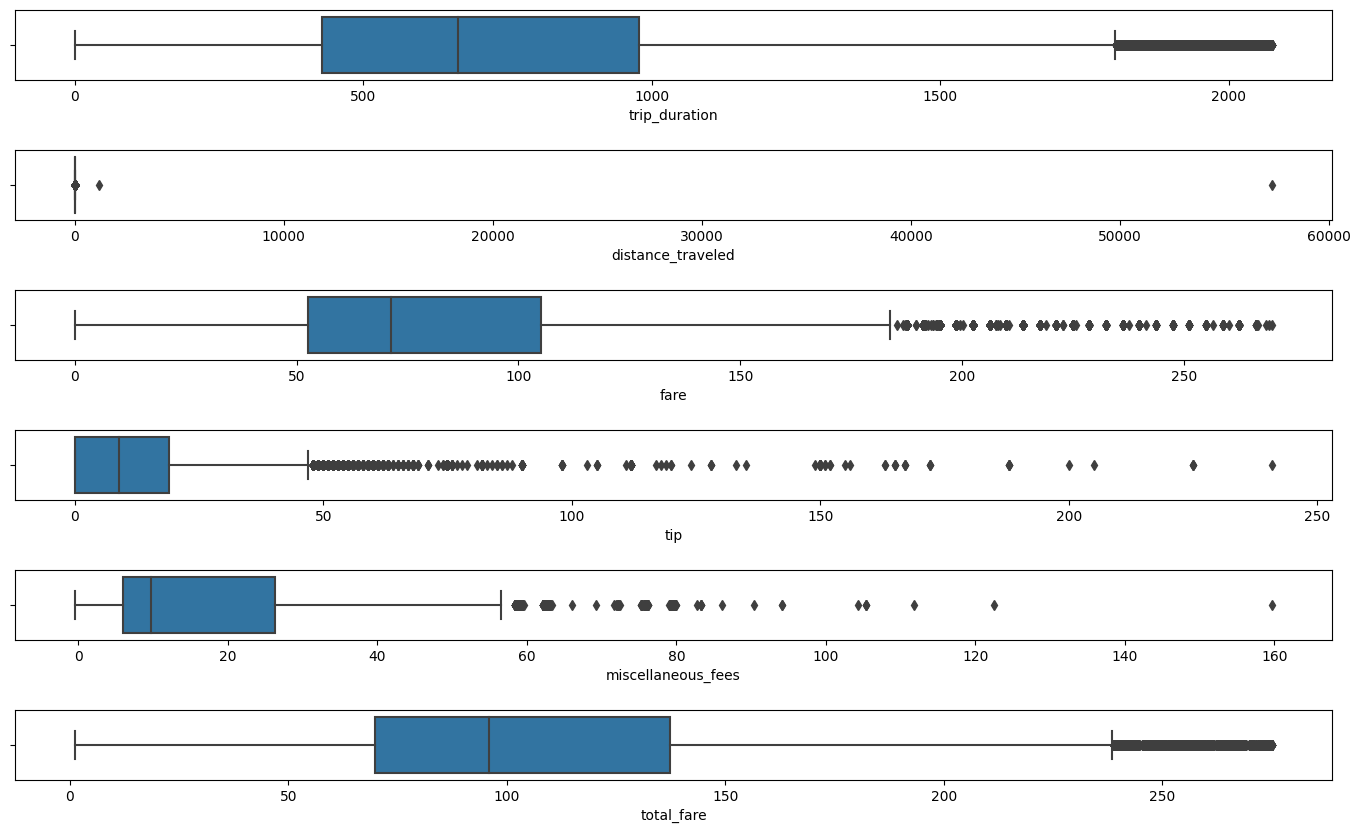

In [18]:
fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(17,10))
fig.subplots_adjust(hspace=1)

for i, col in enumerate(['trip_duration', 'distance_traveled', 'fare',
       'tip', 'miscellaneous_fees', 'total_fare']):
    sns.boxplot(x=col, data=df_taxi_sinatipicos, ax=ax[i])

Recortamos distance_traveled

In [19]:
print(f'Tamaño dataset anterior: {df_taxi_sinatipicos.shape}')
#Creamos un df con la variable para recortar
variablerecorte = df_taxi[['distance_traveled']]
#Calculamos los cuartiles
qs = variablerecorte.quantile([.25, .5, .75], numeric_only=True).values
q1 = qs[0][0]
q2 = qs[1][0]
q3 = qs[2][0]
# Definir límites inferior y superior, a partir de los cuales los datos serían considerados como atípicos
iqr = q3-q1
iqr_lim_inf = q1 - 1.5*iqr
iqr_lim_sup = q3 + 1.5*iqr
#Aquí le indicamos que elimine los atipicos del nuevo dataframe
df_taxi_sinatipicos = df_taxi_sinatipicos[
    (df_taxi_sinatipicos['distance_traveled']>=iqr_lim_inf) & (df_taxi_sinatipicos['distance_traveled']<=iqr_lim_sup)
]
print(f'Tamaño dataset recortado: {df_taxi_sinatipicos.shape}')

Tamaño dataset anterior: (192367, 8)
Tamaño dataset recortado: (186565, 8)


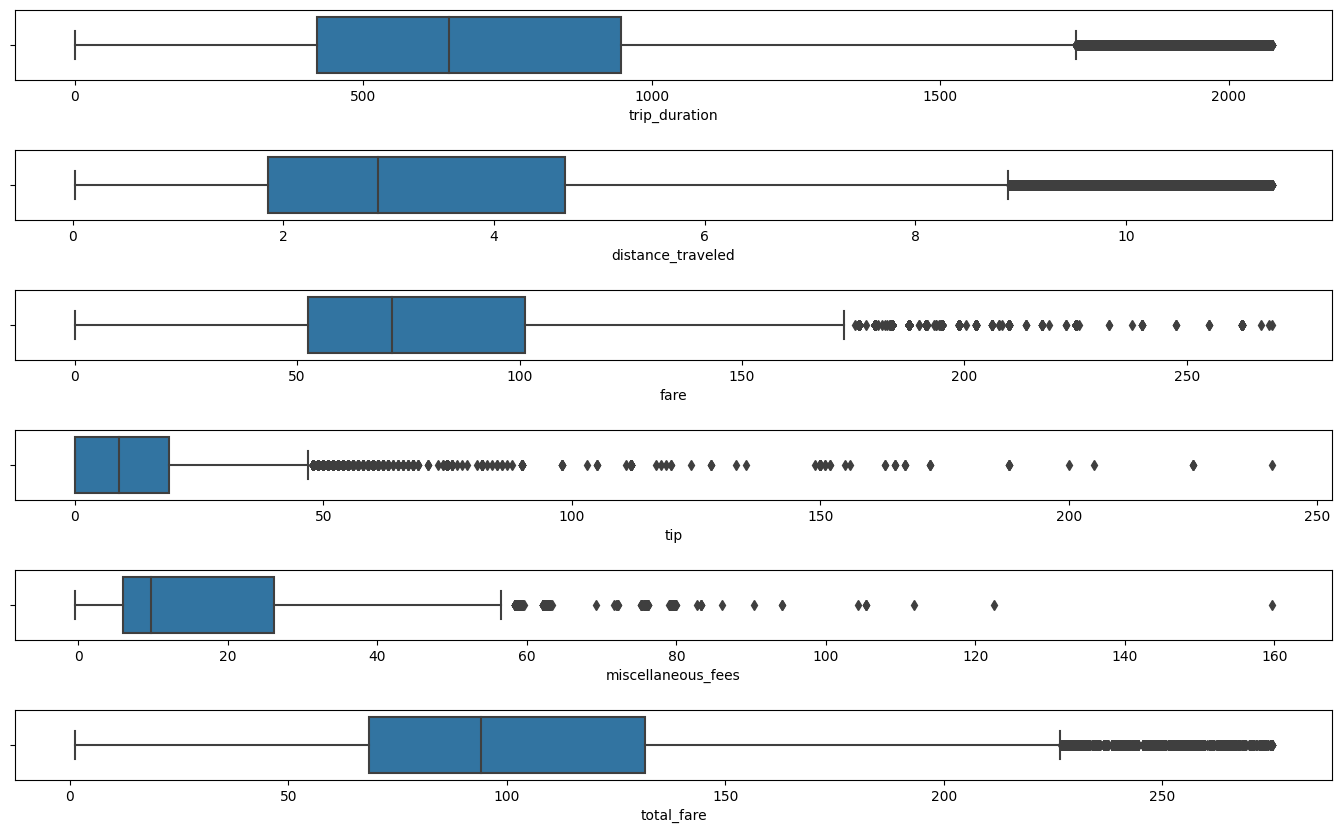

In [20]:
fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(17,10))
fig.subplots_adjust(hspace=1)

for i, col in enumerate(['trip_duration', 'distance_traveled', 'fare',
       'tip', 'miscellaneous_fees', 'total_fare']):
    sns.boxplot(x=col, data=df_taxi_sinatipicos, ax=ax[i])

Recortamos fare

In [21]:
print(f'Tamaño dataset anterior: {df_taxi_sinatipicos.shape}')
#Creamos un df con la variable para recortar
variablerecorte = df_taxi[['fare']]
#Calculamos los cuartiles
qs = variablerecorte.quantile([.25, .5, .75], numeric_only=True).values
q1 = qs[0][0]
q2 = qs[1][0]
q3 = qs[2][0]
# Definir límites inferior y superior, a partir de los cuales los datos serían considerados como atípicos
iqr = q3-q1
iqr_lim_inf = q1 - 1.5*iqr
iqr_lim_sup = q3 + 1.5*iqr
#Aquí le indicamos que elimine los atipicos del nuevo dataframe
df_taxi_sinatipicos = df_taxi_sinatipicos[
    (df_taxi_sinatipicos['fare']>=iqr_lim_inf) & (df_taxi_sinatipicos['fare']<=iqr_lim_sup)
]
print(f'Tamaño dataset recortado: {df_taxi_sinatipicos.shape}')

Tamaño dataset anterior: (186565, 8)
Tamaño dataset recortado: (186289, 8)


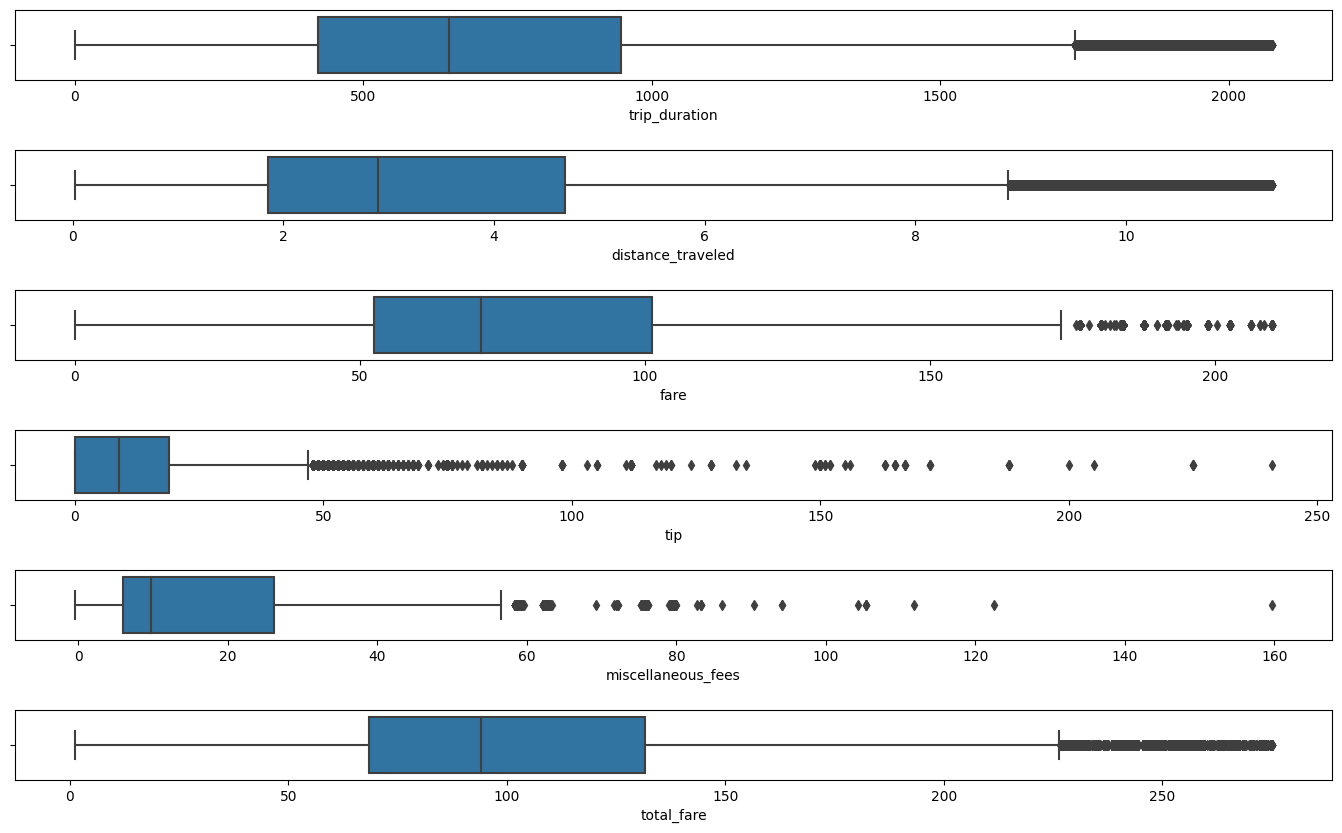

In [22]:
fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(17,10))
fig.subplots_adjust(hspace=1)

for i, col in enumerate(['trip_duration', 'distance_traveled', 'fare',
       'tip', 'miscellaneous_fees', 'total_fare']):
    sns.boxplot(x=col, data=df_taxi_sinatipicos, ax=ax[i])

Recortamos tip

In [23]:
print(f'Tamaño dataset anterior: {df_taxi_sinatipicos.shape}')
#Creamos un df con la variable para recortar
variablerecorte = df_taxi[['tip']]
#Calculamos los cuartiles
qs = variablerecorte.quantile([.25, .5, .75], numeric_only=True).values
q1 = qs[0][0]
q2 = qs[1][0]
q3 = qs[2][0]
# Definir límites inferior y superior, a partir de los cuales los datos serían considerados como atípicos
iqr = q3-q1
iqr_lim_inf = q1 - 1.5*iqr
iqr_lim_sup = q3 + 1.5*iqr
#Aquí le indicamos que elimine los atipicos del nuevo dataframe
df_taxi_sinatipicos = df_taxi_sinatipicos[
    (df_taxi_sinatipicos['tip']>=iqr_lim_inf) & (df_taxi_sinatipicos['tip']<=iqr_lim_sup)
]
print(f'Tamaño dataset recortado: {df_taxi_sinatipicos.shape}')

Tamaño dataset anterior: (186289, 8)
Tamaño dataset recortado: (185036, 8)


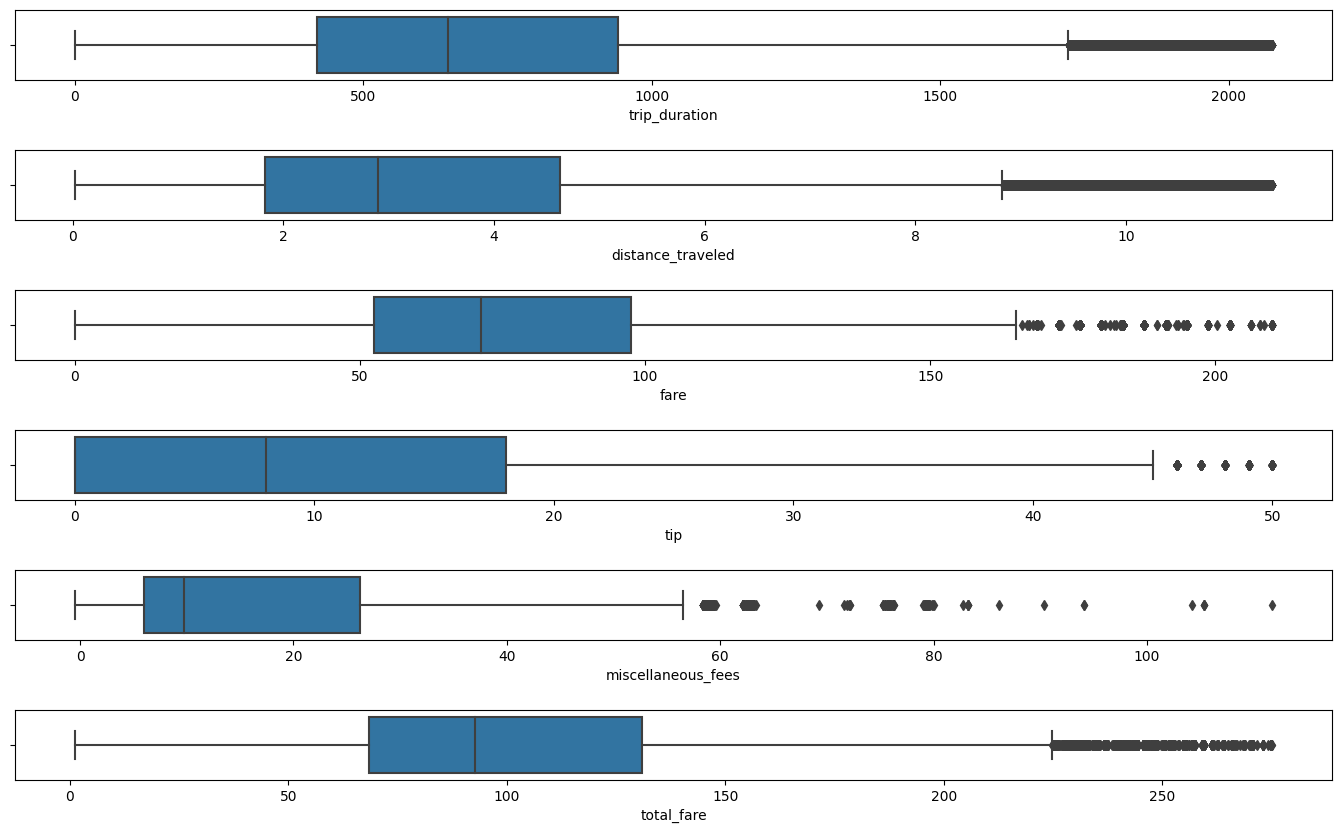

In [24]:
fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(17,10))
fig.subplots_adjust(hspace=1)

for i, col in enumerate(['trip_duration', 'distance_traveled', 'fare',
       'tip', 'miscellaneous_fees', 'total_fare']):
    sns.boxplot(x=col, data=df_taxi_sinatipicos, ax=ax[i])

Recortamos miscellaneous_fees

In [25]:
print(f'Tamaño dataset anterior: {df_taxi_sinatipicos.shape}')
#Creamos un df con la variable para recortar
variablerecorte = df_taxi[['miscellaneous_fees']]
#Calculamos los cuartiles
qs = variablerecorte.quantile([.25, .5, .75], numeric_only=True).values
q1 = qs[0][0]
q2 = qs[1][0]
q3 = qs[2][0]
# Definir límites inferior y superior, a partir de los cuales los datos serían considerados como atípicos
iqr = q3-q1
iqr_lim_inf = q1 - 1.5*iqr
iqr_lim_sup = q3 + 1.5*iqr
#Aquí le indicamos que elimine los atipicos del nuevo dataframe
df_taxi_sinatipicos = df_taxi_sinatipicos[
    (df_taxi_sinatipicos['miscellaneous_fees']>=iqr_lim_inf) & (df_taxi_sinatipicos['miscellaneous_fees']<=iqr_lim_sup)
]
print(f'Tamaño dataset recortado: {df_taxi_sinatipicos.shape}')

Tamaño dataset anterior: (185036, 8)
Tamaño dataset recortado: (184644, 8)


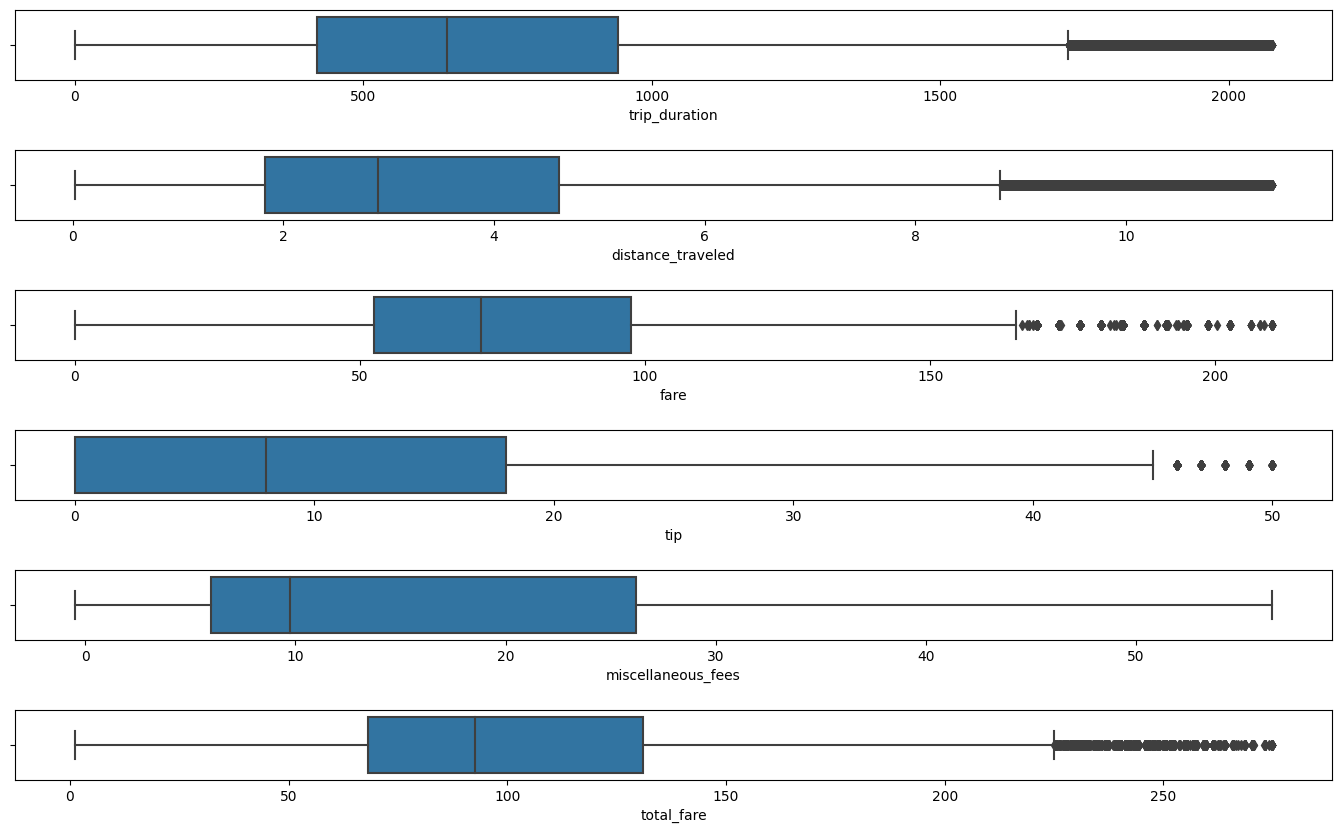

In [26]:
fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(17,10))
fig.subplots_adjust(hspace=1)

for i, col in enumerate(['trip_duration', 'distance_traveled', 'fare',
       'tip', 'miscellaneous_fees', 'total_fare']):
    sns.boxplot(x=col, data=df_taxi_sinatipicos, ax=ax[i])

# Predición de total_fare con regresión lineal simple

## Estudio del conjunto de datos

Vamos a trabajar primero con el dataset sin los atipicos eliminados

In [27]:
corr = df_taxi.corr()
corr

,trip_duration,distance_traveled,fare,tip,miscellaneous_fees,total_fare,surge_applied,trip_duration_hh_mm_ss
trip_duration,1.000000,0.005709,0.150571,0.029219,0.046609,0.142423,0.030047,1.000000
distance_traveled,0.005709,1.000000,0.035977,0.013504,0.021773,0.036727,0.005583,0.005709
fare,0.150571,0.035977,1.000000,0.301750,0.298715,0.966722,0.146319,0.150571
tip,0.029219,0.013504,0.301750,1.000000,0.320628,0.508456,0.239147,0.029219
miscellaneous_fees,0.046609,0.021773,0.298715,0.320628,1.000000,0.452043,0.715439,0.046609
total_fare,0.142423,0.036727,0.966722,0.508456,0.452043,1.000000,0.267022,0.142423
surge_applied,0.030047,0.005583,0.146319,0.239147,0.715439,0.267022,1.000000,0.030047
trip_duration_hh_mm_ss,1.000000,0.005709,0.150571,0.029219,0.046609,0.142423,0.030047,1.000000


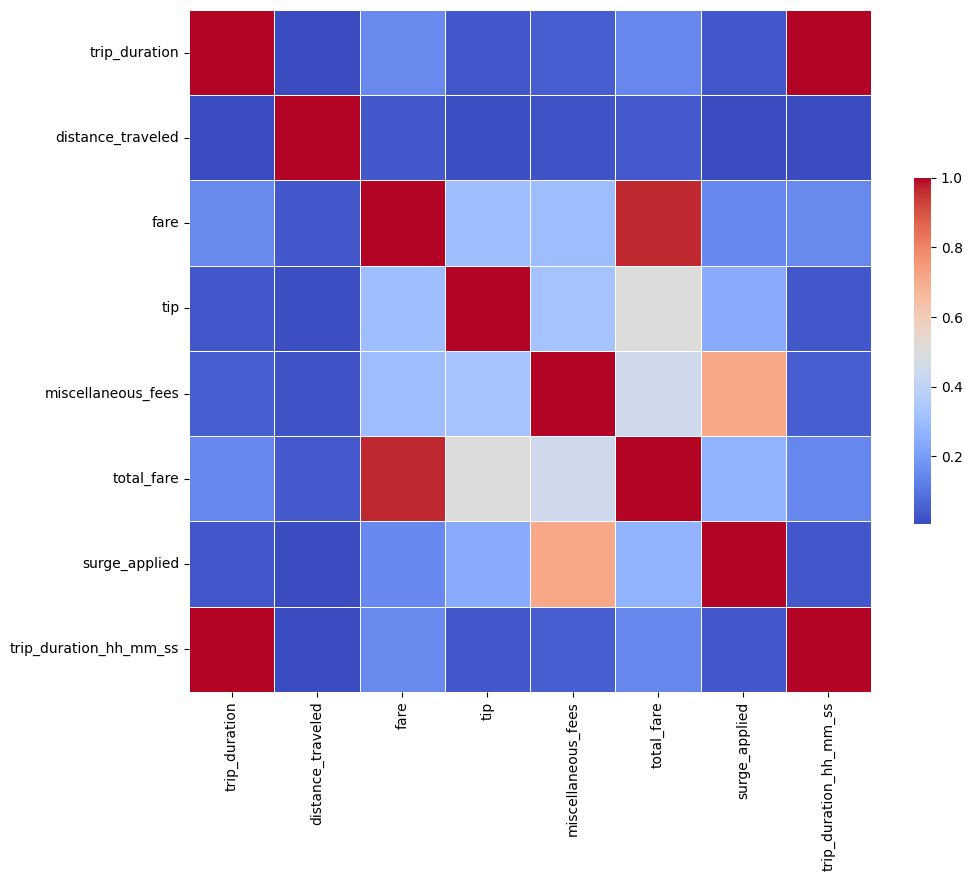

In [28]:
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, cmap='coolwarm', square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

Como parece ser que no hay datos muy correlacionados con total fare, vamos a ver que ocurre utilizando el dataset sin atipicos

In [29]:
corr = df_taxi_sinatipicos.corr()
corr

,trip_duration,distance_traveled,fare,tip,miscellaneous_fees,total_fare,surge_applied,trip_duration_hh_mm_ss
trip_duration,1.000000,0.755685,0.886385,0.297956,0.302601,0.834621,0.316924,1.000000
distance_traveled,0.755685,1.000000,0.906878,0.332547,0.338684,0.867301,0.322441,0.755685
fare,0.886385,0.906878,1.000000,0.336545,0.301539,0.933015,0.314560,0.886385
tip,0.297956,0.332547,0.336545,1.000000,0.362740,0.596404,0.359507,0.297956
miscellaneous_fees,0.302601,0.338684,0.301539,0.362740,1.000000,0.545943,0.896847,0.302601
total_fare,0.834621,0.867301,0.933015,0.596404,0.545943,1.000000,0.532812,0.834621
surge_applied,0.316924,0.322441,0.314560,0.359507,0.896847,0.532812,1.000000,0.316924
trip_duration_hh_mm_ss,1.000000,0.755685,0.886385,0.297956,0.302601,0.834621,0.316924,1.000000


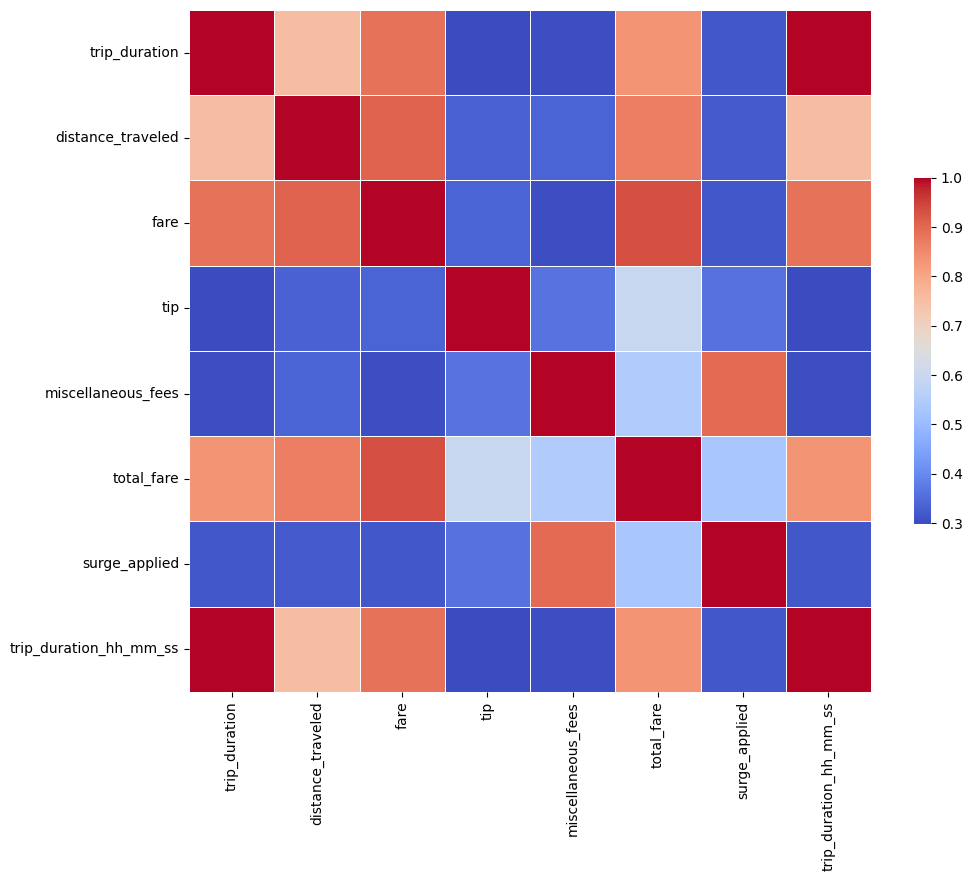

In [30]:
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, cmap='coolwarm', square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

Vemos que en el dataset sin los atipicos hay una mejor correlacion con distance_traveled, además de con fare  
Vamos a probar un modelo de regresión simple con distance travelled puesto que es lógico que si la tarifa es más alta, tenga un alto peso en    
en precio final.

## Regresión lineal simple

Según la paleta de colores elegida nos interesan, para predecir total_fare Las rojas más intensas, que tienen una relación directa.
Ya sabemos que total fare tiene una relación muy directa con fare, puesto que es su principal componente. Para probar con otras variables menos explicitas,  
vamos a ver si la distancia recorrida, nos sirve para predecir la tarifa final.

In [31]:
#Seleccionamos la variable predictora
X = df_taxi_sinatipicos[['distance_traveled']]
#Seleccionamos la variable predicha
y = df_taxi_sinatipicos['total_fare']

In [32]:
X

,distance_traveled
0,2.75
1,3.43
2,3.12
3,5.63
4,2.09
...,...
209667,1.24
209668,8.42
209669,1.29
209670,2.82


In [33]:
y

0         105.300
1         142.200
2          97.875
3          99.750
4          70.200
           ...   
209667     51.000
209668    202.800
209669     95.325
209670     69.750
209671     69.750
Name: total_fare, Length: 184644, dtype: float64

### Visualización del conjunto de datos

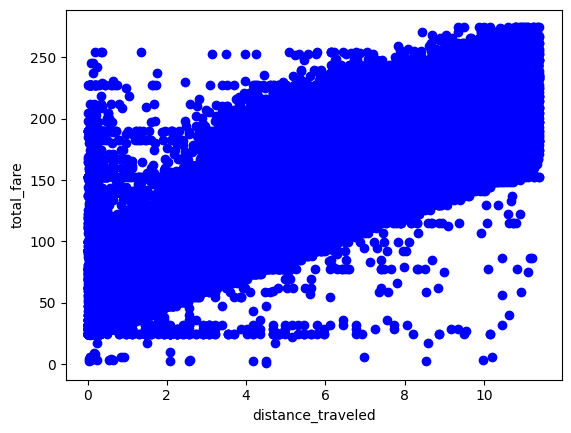

In [34]:
plt.scatter(X, y, color="blue")
plt.xlabel('distance_traveled')
plt.ylabel('total_fare')
plt.show()

### División de datos (conjuntos de entrenamiento y de prueba)
Dividimos los datos en entrenamiento y prueba mediante la instrucción train_test_split. Para la separación de los datos, vamos a tomar un 20% de los mismos para utilizarlos como prueba una vez que hayamos obtenido el modelo

In [35]:
# Dividimos los datos de en entrenamiento y prueba para probar los algoritmos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Dividimos los datos de entrenamiento en desarrollo y validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [36]:
X_train.shape

(110786, 1)

In [37]:
X_test.shape

(36929, 1)

In [38]:
X_val.shape

(36929, 1)

### Creación del modelo de Regresión

In [39]:
# Creación del modelo
lr = LinearRegression()

# Ajuste del modelo al conjunto de datos de entrenamiento
lr.fit(X_train, y_train)

LinearRegression()

### Predicción del conjunto de datos de validación

In [40]:
y_pred = lr.predict(X_val)

### Validacion de resultados

In [41]:
df_res = pd.DataFrame(columns=['Valor Real', 'Valor Predicho'])
df_res['Valor Real'] = y_val
df_res['Valor Predicho'] = y_pred
df_res['Diferencia'] = abs(df_res['Valor Predicho']-df_res['Valor Real'] )
df_res.head()

,Valor Real,Valor Predicho,Diferencia
175226,66.000,72.636400,6.636400
181340,84.750,84.487235,0.262765
162652,45.000,59.583306,14.583306
112089,61.425,66.453355,5.028355
128017,96.000,100.803603,4.803603


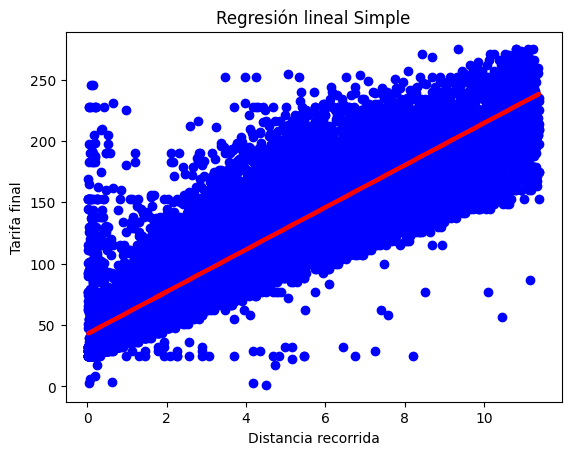

In [42]:
plt.scatter(X_val, y_val, color='blue')
plt.plot(X_val, y_pred, color='red', linewidth=3)
plt.title('Regresión lineal Simple')
plt.xlabel('Distancia recorrida')
plt.ylabel('Tarifa final')
plt.show()

In [43]:
print('progresión del precio =', lr.coef_[0], 'OverallQual +', lr.intercept_)

progresión del precio = 17.175123557006888 OverallQual + 42.75168492410309


### Metricas

In [44]:
print('Raiz error cuadrático medio: %.2f' % np.sqrt(mean_squared_error(y_val, y_pred)))
print('Coeficiente de determinación: %.2f' % r2_score(y_val, y_pred))

Raiz error cuadrático medio: 22.95
Coeficiente de determinación: 0.75


### Predicción de datos futuros

In [45]:
y_pred = lr.predict(X_test)

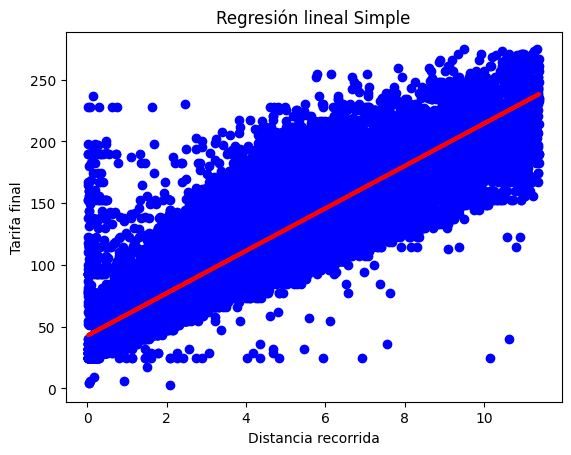

In [46]:
plt.scatter(X_test, y_test, color='blue')
plt.plot(X_test, y_pred, color='red', linewidth=3)
plt.title('Regresión lineal Simple')
plt.xlabel('Distancia recorrida')
plt.ylabel('Tarifa final')
plt.show()

In [47]:
print('Raiz error cuadrático medio: %.2f' % np.sqrt(mean_squared_error(y_test, y_pred)))
print('Coeficiente de determinación: %.2f' % r2_score(y_test, y_pred))

Raiz error cuadrático medio: 22.96
Coeficiente de determinación: 0.75


Aunque nos sale un modelo bastante bueno, vamos a probar a ver que tal saldría con árboles de decisión.

## Modelo arbol de decisión de regresión

## Exploración de datos

Para este modelo vamos a seleccionar las variables distancia recorrida y duración del viaje

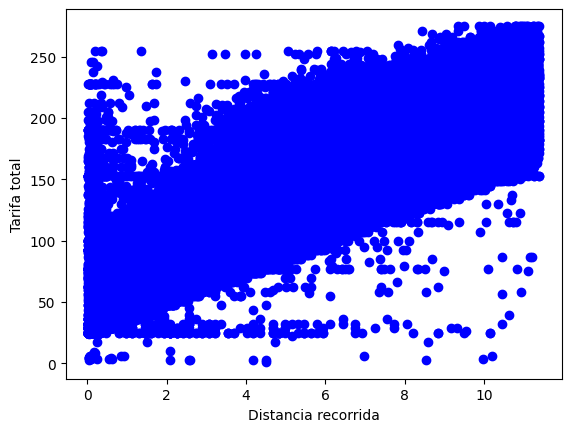

In [48]:
# Visualizamos los datos correspondientes
plt.scatter(df_taxi_sinatipicos['distance_traveled'], df_taxi_sinatipicos['total_fare'], color="blue")
plt.xlabel('Distancia recorrida')
plt.ylabel('Tarifa total')
plt.show()

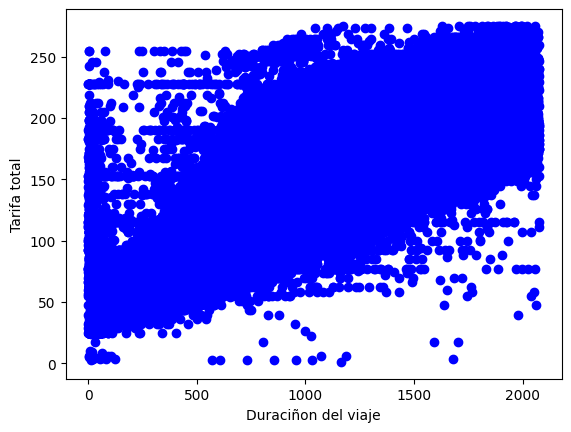

In [49]:
# Visualizamos los datos correspondientes
plt.scatter(df_taxi_sinatipicos['trip_duration'], df_taxi_sinatipicos['total_fare'], color="blue")
plt.xlabel('Duraciñon del viaje')
plt.ylabel('Tarifa total')
plt.show()

## Preprocesamiento de datos

### Selección de datos

In [50]:
# Seleccionamos las características a tener en cuenta para crear el modelo
X = df_taxi_sinatipicos[['distance_traveled','trip_duration']]

In [51]:
# Defino los datos correspondientes a las etiquetas
y = df_taxi_sinatipicos['total_fare']

### División de datos (conjuntos de entrenamiento y de prueba)
Dividimos los datos en entrenamiento y prueba mediante la instrucción train_test_split.
Para la separación de los datos, vamos a tomar un 20% de los mismos para utilizarlos como prueba una vez que hayamos obtenido el modelo.

In [52]:
# Dividimos los datos de "entrenamiento" en entrenamiento y prueba para probar los algoritmos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Creación del modelo de Regresión

In [53]:
# Creación del modelo
reg = DecisionTreeRegressor(random_state=0, max_depth=3)

# Ajuste del modelo al conjunto de datos de entrenamiento
reg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3, random_state=0)

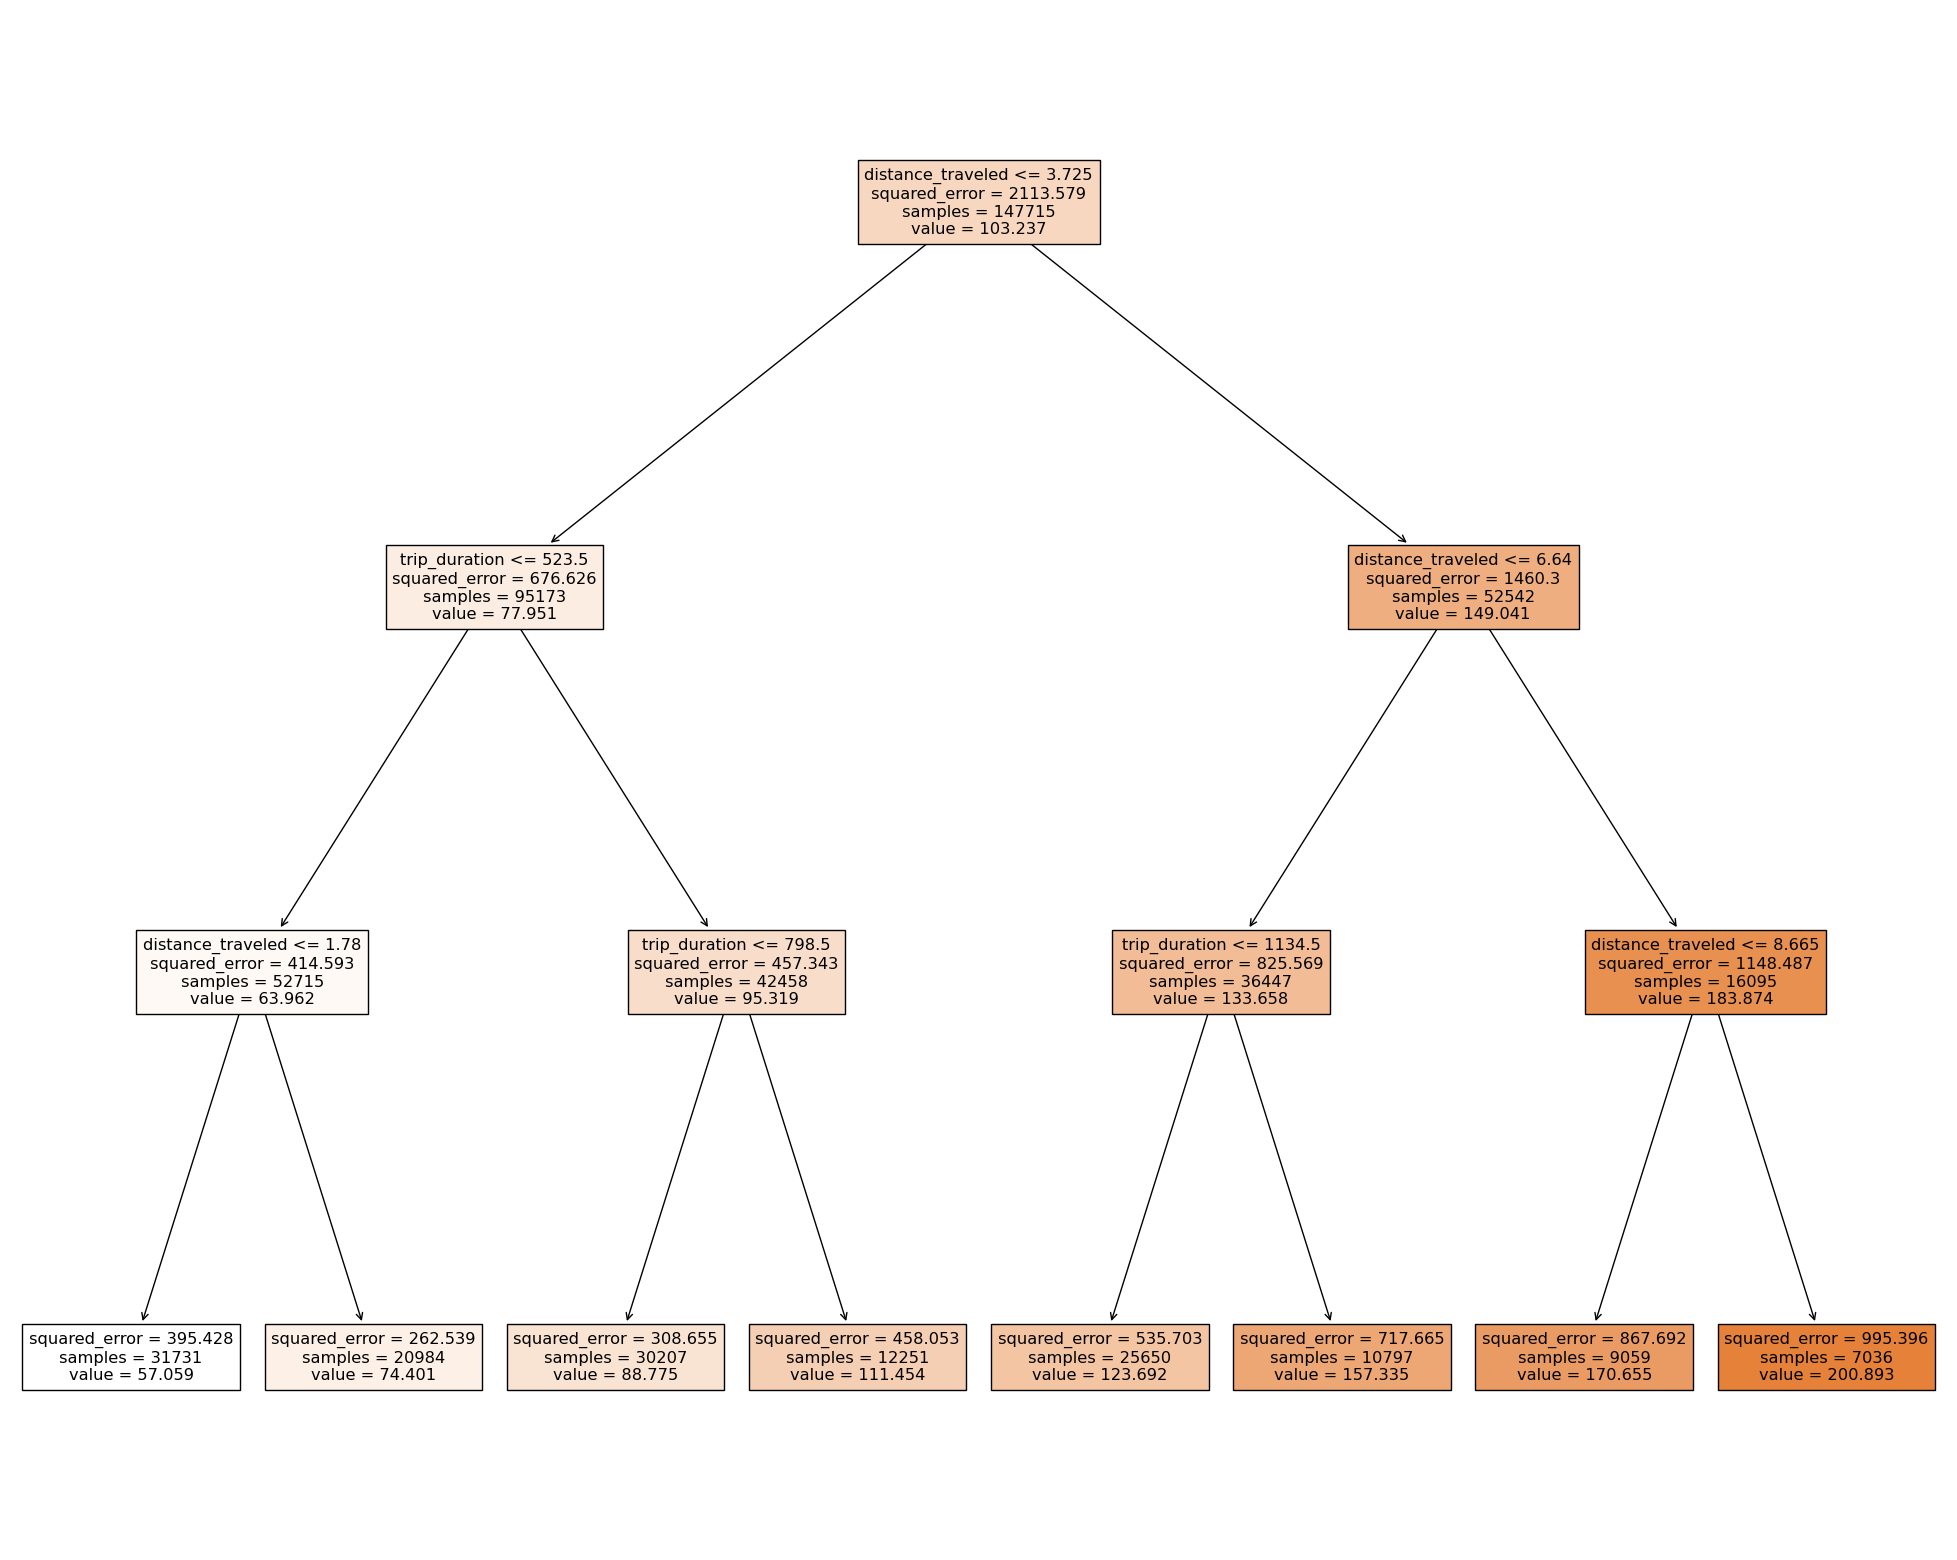

In [54]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(reg, 
                   feature_names=X.columns,
                   filled=True)

## Predicción del conjunto de datos de prueba

In [55]:
# Predicción del conjunto de datos de prueba
y_pred = reg.predict(X_test)

## Validación de resultados

In [56]:
df_resultados =  pd.DataFrame(columns=['Valor Real', 'Valor Predicho'])
df_resultados['Valor Real'] = y_test
df_resultados['Valor Predicho'] = y_pred
df_resultados.head()

,Valor Real,Valor Predicho
104956,51.00,57.058750
146796,66.00,57.058750
111782,256.95,200.892798
177042,114.75,111.453777
99437,115.35,88.775444


## Métricas

In [59]:
print("Raíz error cuadrático medio: %.2f" % np.sqrt(mean_squared_error(y_test, y_pred)))
print("Coeficiente de determinación: %.2f" % r2_score(y_test, y_pred))

Raíz error cuadrático medio: 21.48
Coeficiente de determinación: 0.78


Como podemos observar, el modelo de árboles de decisión es mejor que el modelo de regresión lineal simple. No sólo la distancia recorrida influye en la tarifa final  
también hay que tener en cuenta el factor del tiempo que dura el viaje, pues aunque la distancia sea corta, puede haber atascos, velocidad limitada, y el conductor  
debe sacar una rentabilidad por el tiempo que trabaja.  
Además, en este último modelo, el error cuadrático medio es menor, lo que significa que hay menos probabilidad de que los resultados disten de los previstos.  
Los resultados de este modelo se parecen más a las tarifas reales si tenemos en cuenta el ejemplo anterior.